In [1]:
"""
July 7, 2020

Adding another blob
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

Ms = np.linspace(7, 12, 60)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

# blob 2: the sfrd
blob_n2 = ['galaxy_sfrd']
blob_i2 = [('z', redshifts)]
blob_f2 = ['SFRD']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

In [47]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')
# ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

#to actually use
# ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

# ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

# ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

# ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
# ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [38]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [39]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

In [40]:
# base_pars.update(guesses)
# pop = ares.populations.GalaxyPopulation(**base_pars)

# z = 1

# smf = pop.StellarMassFunction(z, Ms)
# pl.semilogy(Ms, smf, label='guess')
# data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

# pl.legend()
# pl.show()

In [41]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [42]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 20

fitter.jitter = [0.1] * len(fitter.parameters)

fitter.guesses = guesses

# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.16371781872738767 to 0.07652000068796341
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.031312091669967415 to 0.07219313536945517
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.13073569104998428 to 0.06931045753127556
# Fixing position of walker 13 (parameter pq_func_par0[1])
# Moved from -0.03351276212148438 to 0.14213981957373553
# Fixing position of walker 14 (parameter pq_func_par0[1])
# Moved from -0.012574494347721666 to 0.1470118817898872
# Fixing position of walker 15 (parameter pq_func_par0[1])
# Moved from -0.014652290549171668 to 0.18249494233152394


In [ ]:
fitter.run('MCMC_files/blob_test2', burn=5, steps=25, save_freq=1, clobber=True)

In [6]:
anl = ares.analysis.ModelSet('MCMC_files/blob_test1')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : blob_test1                                                                             ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/blob_test1.dd*.chain.pkl...
# Loaded MCMC_files/blob_test1.dd*.chain.pkl in 0.059 s.
# Loaded MCMC_files\blob_test1.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0009.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0010.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0011.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0012.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0013.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test1.dd0014.bl

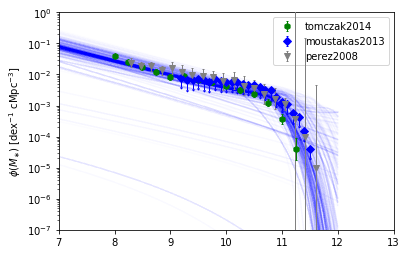

In [7]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [8]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 9.107346e-01
pq_func_par2[0]: 1.783674e-01
pq_func_par0[1]: 8.728727e-02
pq_func_par2[1]: -8.580990e-01
pq_func_par0[2]: 7.018866e-01
pq_func_par2[2]: -2.010368e-01
pq_func_par0[3]: 1.215540e+01
pq_func_par2[3]: 1.034066e-01


0 of 780 chain elements ignored because of chain links with inf's/nan's.


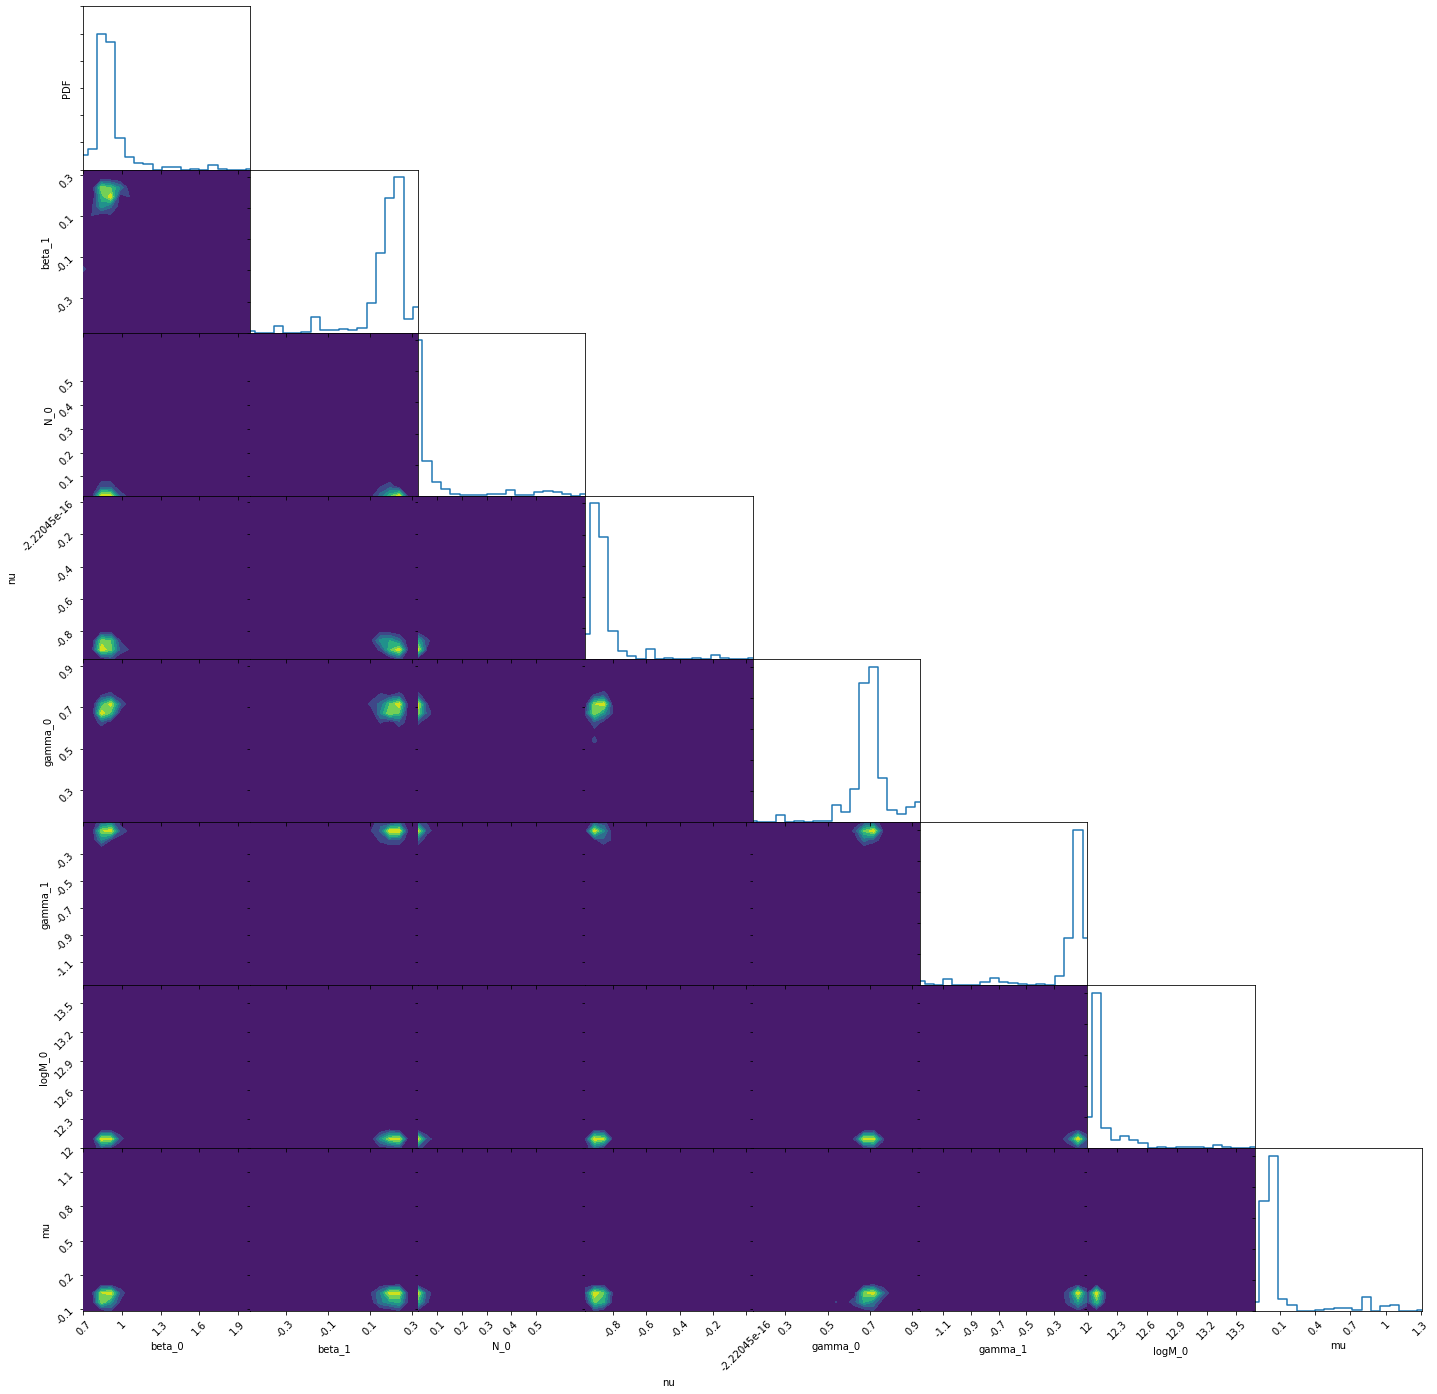

In [9]:

trig = anl.TrianglePlot(pars=params)

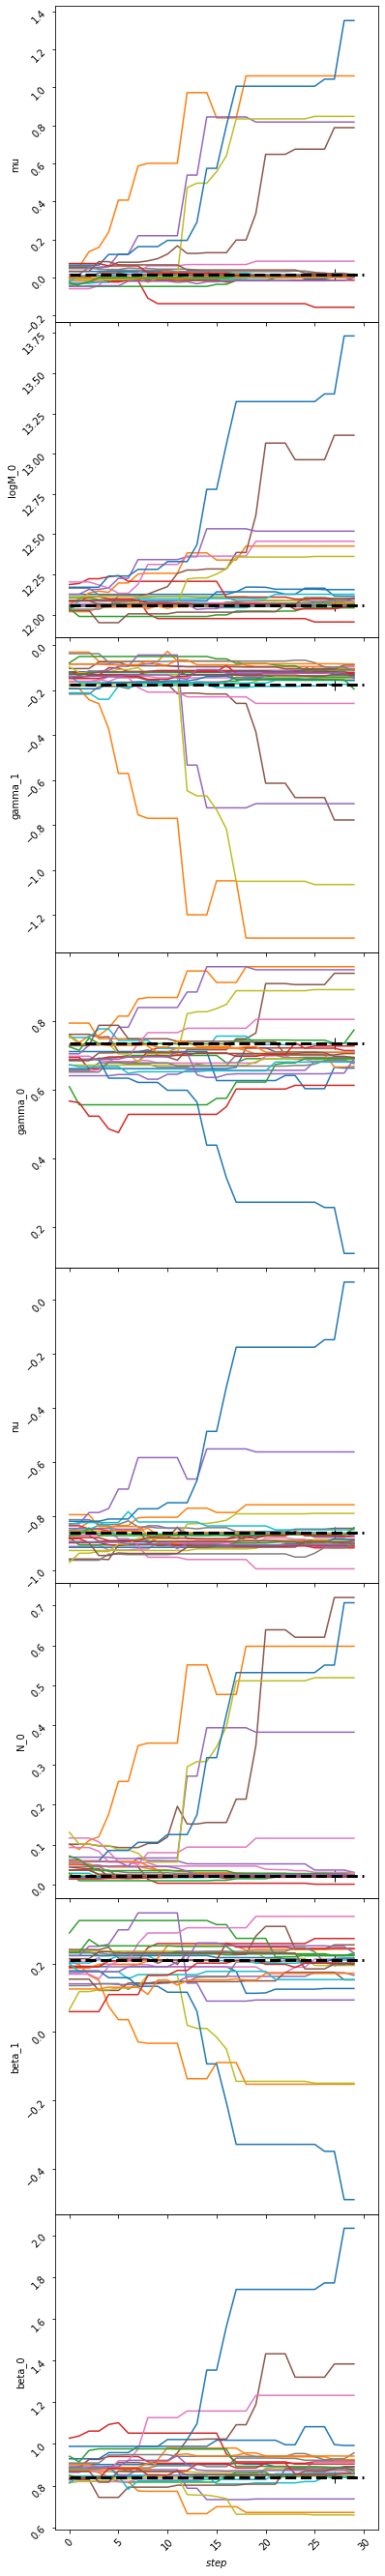

In [10]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [11]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 0.8390192940165602,
 'pq_func_par2[0]': 0.2105243786295194,
 'pq_func_par0[1]': 0.022769683362509386,
 'pq_func_par2[1]': -0.8636572957386243,
 'pq_func_par0[2]': 0.7347552289223998,
 'pq_func_par2[2]': -0.1734352783793937,
 'pq_func_par0[3]': 12.056802221324038,
 'pq_func_par2[3]': 0.013646302423142421}

In [12]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 9.107346e-01
pq_func_par2[0]: 1.783674e-01
pq_func_par0[1]: 8.728727e-02
pq_func_par2[1]: -8.580990e-01
pq_func_par0[2]: 7.018866e-01
pq_func_par2[2]: -2.010368e-01
pq_func_par0[3]: 1.215540e+01
pq_func_par2[3]: 1.034066e-01


In [13]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [14]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(0.8390192940165602, array([0.13682684, 0.01124453]))
(0.2105243786295194, array([0.03813267, 0.07473612]))
(0.022769683362509386, array([0.07926234, 0.00396552]))
(-0.8636572957386243, array([0.03173231, 0.05229737]))
(0.7347552289223998, array([0.0166863, 0.083181 ]))
(-0.1734352783793937, array([0.08194483, 0.01412133]))
(12.056802221324038, array([0.18987537, 0.00529556]))
(0.013646302423142421, array([0.07130215, 0.02974799]))


In [15]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 0.8390192940165602, 'pq_func_par2[0]': 0.2105243786295194, 'pq_func_par0[1]': 0.022769683362509386, 'pq_func_par2[1]': -0.8636572957386243, 'pq_func_par0[2]': 0.7347552289223998, 'pq_func_par2[2]': -0.1734352783793937, 'pq_func_par0[3]': 12.056802221324038, 'pq_func_par2[3]': 0.013646302423142421}


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


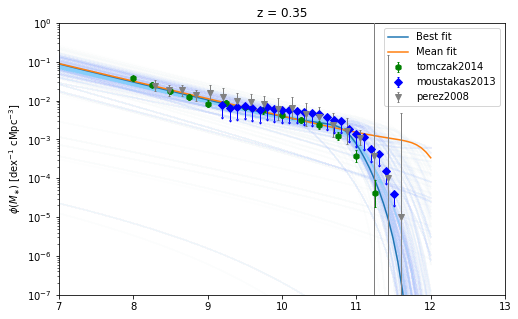

In [16]:
z = 0.35

fig, ax = pl.subplots(figsize=(8, 5))
Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

# print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
50


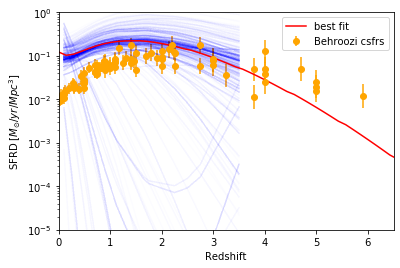

In [25]:
Zs = np.linspace(0, 7, 50)

import UsefulHODFunctions as UHF
csfrs, err = UHF.getCsfrsData()

ax = anl.ReconstructedFunction('galaxy_sfrd', ivar=None, samples='all', color='b', alpha=0.01)

SFRD_mod = pop_best.SFRD(Zs)
# print(SFRD_mod)

ax.semilogy(Zs, SFRD_mod, label="best fit", color='r')

ax.errorbar(csfrs[0], 10**csfrs[1], yerr=[err[0], err[1]], ls="", marker="o", color="orange", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.ylim(1e-5, 1e0)
pl.xlim(0, 6.5)

pl.show()